## Package import

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import *
from sklearn.linear_model import BayesianRidge
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings

### 自定義函數：用來計算預估能獲得的最高f1分數

In [3]:
# chrck y_pred
def checkFunction(y_pred):
    num0=0
    num1=0
    for i in y_pred:
        if i==0:
            num0+=1
        else:
            num1+=1

    a=0
    b=0
    c=0
    d=0

    if num0>566:
        d=566
        c=0
        b=num0-566
        a=700-b
    else:
        d=num0
        c=566-num0
        a=700
        b=0

    f1_max=2*a/(2*a+b+c)
    print("f1_max : ",f1_max)

## EDA

### 資料讀取&清理

In [4]:
'''讀取原始資料&將資料轉換成dataframe'''
original_training_data = pd.read_csv('./train.csv')
training_data_df = original_training_data.iloc[:, :-1]
last_column = original_training_data.iloc[:, -1].to_numpy()

'''刪除原始資料缺失值過多及與題目無關的feature'''
training_data_df = training_data_df.drop(['D_sds','D_sd1','D_td0','D_sms','D_sm1','D_tm0','D_Ra_Capacity','D_Ra_CDR'], axis=1)
training_data_np = training_data_df.to_numpy()

'''讀取測試資料&將資料轉換成dataframe'''
testing_data = pd.read_csv('./X_test.csv')
testing_data_df = testing_data.copy()

'''測試資料刪除缺失值過多及與題目無關的feature'''
testing_data_df = testing_data_df.drop(['D_sds','D_sd1','D_td0','D_sms','D_sm1','D_tm0','D_Ra_Capacity','D_Ra_CDR'], axis=1)
testing_data_np = testing_data_df.to_numpy()

### 資料處理：年代異常、Outlier、NaN、Scaler

In [5]:
'''年代資料處理'''
def day_to_year(dataframe):
    dataframe_column = dataframe['D_Dbuild']
    condition = (dataframe_column > 3000) | (dataframe_column < -3000)
    dataframe_column[condition] = dataframe_column[condition] / 31557600 + 1970
    dataframe['D_Dbuild'] = dataframe_column
day_to_year(training_data_df)

'''將大於90%值設為NaN，小於0的改為0'''
for column in training_data_df:
    column_stats = training_data_df[column].describe(percentiles=[0.90])
    upper_limit = column_stats["90%"]
    training_data_df[column] = training_data_df[column].apply(lambda x: np.nan if x > upper_limit * 20 else x)
    training_data_df[column] = training_data_df[column].apply(lambda x: 0 if x < 0 else x)

'''缺項值填補'''
imputer = IterativeImputer(estimator=BayesianRidge(n_iter=300,tol=1e-2),imputation_order='ascending',max_iter=30,random_state=42)
training_data_np = imputer.fit_transform(training_data_df)
testing_data_np = imputer.transform(testing_data_df)

training_data_df = pd.DataFrame(training_data_np, columns=training_data_df.columns)
training_data_df.head(20)

'''RobustScaler處理'''
scaler = RobustScaler()
training_data_np = scaler.fit_transform(training_data_np)
testing_data_np = scaler.transform(testing_data_np)
training_data_df = pd.DataFrame(training_data_np, columns=training_data_df.columns)
training_data_df.describe(percentiles=[0.1,0.25,0.5,0.75,0.9])

'''確認XY資料大小'''
X = training_data_df
Y = last_column

### 重要特徵篩選

In [6]:
'''permutation_importance'''
model=XGBClassifier(n_estimators=300, max_depth=20,learning_rate=0.1,gamma=0.2,scale_pos_weight=670/2664,random_state=42)
model.fit(X, Y)
perm_importance = permutation_importance(model, X, Y, random_state=42)
importance = perm_importance.importances_mean
importance = pd.DataFrame(importance)

'''permutation_importance資料分切'''
filtered_importance_df=importance.nlargest(11,0)
filtered_features =[]
for i in filtered_importance_df[0].index:
    filtered_features.append(training_data_df.columns[i])
filtered_features_df = training_data_df[filtered_features]

'''確認最終XY資料大小'''
X = filtered_features_df
Y = last_column

### 原始資料reload並僅使用重要feature做data preprocessing：Outlier處理、NaN、Scaler

In [7]:
'''重新讀取原始資料並對重要欄位做資料預處理'''
warnings.filterwarnings("ignore")   

training_data_df = original_training_data[filtered_features]
testing_data_df = testing_data_df[filtered_features]

for column in training_data_df:
    column_stats = training_data_df[column].describe(percentiles=[0.90])
    upper_limit = column_stats["90%"]
    training_data_df[column] = training_data_df[column].apply(lambda x: np.nan if x > upper_limit * 20 else x)
    training_data_df[column] = training_data_df[column].apply(lambda x: 0 if x < 0 else x)

imputer = IterativeImputer(estimator=BayesianRidge(n_iter=300,tol=1e-2),imputation_order='ascending',max_iter=30,random_state=42)
training_data_np = imputer.fit_transform(training_data_df)
testing_data_np = imputer.transform(testing_data_df)
training_data_df = pd.DataFrame(training_data_np, columns=training_data_df.columns)
testing_data_df = pd.DataFrame(testing_data_np, columns=testing_data_df.columns)

scaler = RobustScaler()
training_data_np = scaler.fit_transform(training_data_df)
testing_data_np = scaler.transform(testing_data_df)
training_data_df = pd.DataFrame(training_data_np, columns=training_data_df.columns)

### 訓練資料讀取，並進行SMOTE

In [14]:
'''對imbalanced data進行處理'''
X = training_data_df
Y = last_column

X, Y = SMOTE(random_state=42,k_neighbors=7).fit_resample(X, Y)

## Model Tuning

### XGBClassifier(feature=8)
Best score: {'class_weight': 'balanced', 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 300, 'reg_alpha': 1, 'reg_lambda': 1}

In [9]:
'''tuning best parameter'''
model=XGBClassifier(n_estimators=300, max_depth=15,learning_rate=0.05,gamma=0,scale_pos_weight=1,reg_alpha=1, reg_lambda = 1, random_state=42)
model.fit(X, Y)

results1 = cross_val_score(model, X, Y, cv=5,scoring='accuracy')
results2 = cross_val_score(model, X, Y, cv=5,scoring='f1')

print("accuracy = ",results1.mean())
print("f1 = ",results2.mean())

X_test = testing_data_np
predictions = model.predict(X_test)

ids = np.arange(1, 1267)
predictions_series = pd.Series(predictions)
predictions_df = pd.DataFrame({'id': ids, 'label': predictions_series})

class_counts = predictions_df.groupby('label').size()
print(class_counts)
checkFunction(predictions)

accuracy =  0.8541912639061385
f1 =  0.86733188549697
label
0    281
1    985
dtype: int64
f1_max :  0.8308605341246291


### ExtraTreesClassifier(feature=9)


In [11]:
model= ExtraTreesClassifier(random_state=42)
model.fit(X, Y)

results1 = cross_val_score(model, X, Y, cv=5,scoring='accuracy')
results2 = cross_val_score(model, X, Y, cv=5,scoring='f1')

print("accuracy = ",results1.mean())
print("f1 = ",results2.mean())

X_test = testing_data_np
predictions = model.predict(X_test)

ids = np.arange(1, 1267)
predictions_series = pd.Series(predictions)
predictions_df = pd.DataFrame({'id': ids, 'label': predictions_series})

class_counts = predictions_df.groupby('label').size()
print(class_counts)
checkFunction(predictions)

accuracy =  0.9091671731451877
f1 =  0.9087553804446966
label
0    289
1    977
dtype: int64
f1_max :  0.8348240906380441


### RandomForestClassifier(feature=11)
- Best score: {'class_weight': 'balanced', 'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
- accuracy =  0.7975404189796993
- f1 =  0.8851809433092288
- label
- 0     157
- 1    1109
- f1_max :  0.7739082365948038

In [13]:
model = RandomForestClassifier(random_state=42) #kaggle=0.79775
model.fit(X, Y)

results1 = cross_val_score(model, X, Y, cv=5,scoring='accuracy')
results2 = cross_val_score(model, X, Y, cv=5,scoring='f1')

print("accuracy = ",results1.mean())
print("f1 = ",results2.mean())

X_test = testing_data_np
predictions = model.predict(X_test)

ids = np.arange(1, 1267)
predictions_series = pd.Series(predictions)
predictions_df = pd.DataFrame({'id': ids, 'label': predictions_series})

class_counts = predictions_df.groupby('label').size()
print(class_counts)
checkFunction(predictions)

accuracy =  0.8697597970562588
f1 =  0.8723420513268902
label
0    337
1    929
dtype: int64
f1_max :  0.8594229588704727


### Voting

In [30]:
'''VotingClassifier'''
'''RandomForestClassifier'''
params = {
    'n_estimators': [100, 200,300,400, 500,600,700,800,900,1000],
    'max_depth': [None,3, 5, 7, 9],
    'min_samples_split': [2,4,5],
    'min_samples_leaf': [1,2,4,5],
    'max_leaf_nodes': [None, 10, 20, 30],
    'class_weight': ['balanced']
}
gs1 = GridSearchCV(RandomForestClassifier(n_jobs=-1,random_state=42), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='f1')
gs1.fit(X, Y)
print("RandomForestClassifier")
print('Best score:', gs1.best_score_)
print('Best score:', gs1.best_params_)
##########################################################################################
'''XGBClassifier'''
params = {
    'n_estimators': [100, 200,300,400, 500,600,700,800,900,1000],
    'learning_rate': [0.01,0.05,0.1,0.2,0.3],
    'gamma': [0, 0.2, 0.5],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 3,5],
    'max_depth': [3, 5,6, 7, 9, 11, 13, 15,17,20],
}
model = XGBClassifier(n_jobs=-1,random_state=42)
gs2 = GridSearchCV(XGBClassifier(n_jobs=-1,random_state=42), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='f1')
gs2.fit(X, Y)
print("XGBClassifier")
print('Best score:', gs2.best_score_)
print('Best score:', gs2.best_params_)
##########################################################################################
'''ExtraTreesClassifier'''
params = {
    'n_estimators': [100, 200,300,400, 500,600,700,800,900,1000],
    'max_depth': [None,3, 5, 7, 9],
    'min_samples_split': [1,2,4,5,7,10],
    'min_samples_leaf': [1,2,4,5,7,10],
    'max_leaf_nodes': [4,8,10,15,20,50,None]
}
gs3 = GridSearchCV(ExtraTreesClassifier(n_jobs=-1), params, n_jobs=-1, cv=KFold(n_splits=3), scoring='f1')
gs3.fit(X, Y)
print("ExtraTreesClassifier")
print('Best score:', gs3.best_score_)
print('Best score:', gs3.best_params_)

In [15]:
votes = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('xgb',XGBClassifier(n_estimators=400, max_depth=17,learning_rate=0.1,gamma=0.2,scale_pos_weight=1,random_state=42)),
    ('xt', ExtraTreesClassifier(random_state=42)),
]

# votes = [
#     ('rf', gs1.best_estimator_),
#     ('xgb', gs2.best_estimator_),
#     ('xt', gs3.best_estimator_),
# ]

votesClass = VotingClassifier(estimators=votes, voting='hard',weights=[1,1,1],n_jobs=-1)
votesClass_cv = cross_validate(votesClass, X, Y, cv=KFold(3))
votesClass.fit(X, Y)

model = votesClass

results1 = cross_val_score(model, X, Y, cv=5,scoring='accuracy')
results2 = cross_val_score(model, X, Y, cv=5,scoring='f1')

print("accuracy = ",results1.mean())
print("f1 = ",results2.mean())

X_test = testing_data_np
predictions = model.predict(X_test)

ids = np.arange(1, 1267)
predictions_series = pd.Series(predictions)
predictions_df = pd.DataFrame({'id': ids, 'label': predictions_series})

class_counts = predictions_df.groupby('label').size()
print(class_counts)
checkFunction(predictions)

accuracy =  0.8896546256903524
f1 =  0.8938956905888482
label
0    302
1    964
dtype: int64
f1_max :  0.8413461538461539


### Performance report

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model.fit(X_train, Y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(Y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(Y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(Y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(Y_test, y_test_hat))

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.2,
                                            gpu_id=None, grow_policy=None,
                                            importance_type...
                                            interaction_constraints=None,
                                            learning_rate

### Hyperparameters tuning validation plot

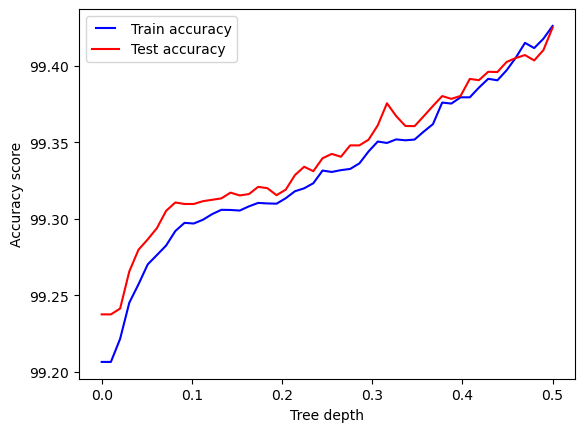

In [89]:
max_depths = np.linspace(0, 0.5, 50, dtype=float,endpoint=True)
# max_depths = np.arange(1, 50, 1).astype(int)

train_results = []
test_results = []

for i in max_depths:
    try:
        dt = RandomForestClassifier(min_samples_split=45,min_samples_leaf =40,min_weight_fraction_leaf=0.5,random_state=42)
        dt.fit(x_train, y_train)    
        #compute accuracy for train data
        housing_tree = dt.predict(x_train)
        errors = abs(housing_tree - y_train)
        # Calculate mean absolute percentage error (MAPE)
        mape = 100 * (errors / y_train)
        # Calculate and display accuracy
        accuracy = 100 - np.mean(f1_score(y_train, housing_tree, average=None))
        #append results of accuracy
        train_results.append(accuracy)
        
        #now again for test data
        housing_tree = dt.predict(x_test)
        errors = abs(housing_tree - y_test)
        # Calculate mean absolute percentage error (MAPE)
        mape = 100 * (errors / y_test)
        # Calculate and display accuracy
        accuracy = 100 - np.mean(f1_score(y_test, housing_tree, average=None))
        #append results of accuracy
        test_results.append(accuracy)
    except Exception as e:
        print(f"Error at depth {i}: {str(e)}")
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train accuracy')
line2, = plt.plot(max_depths, test_results, 'r', label= 'Test accuracy')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('Tree depth')
plt.show()

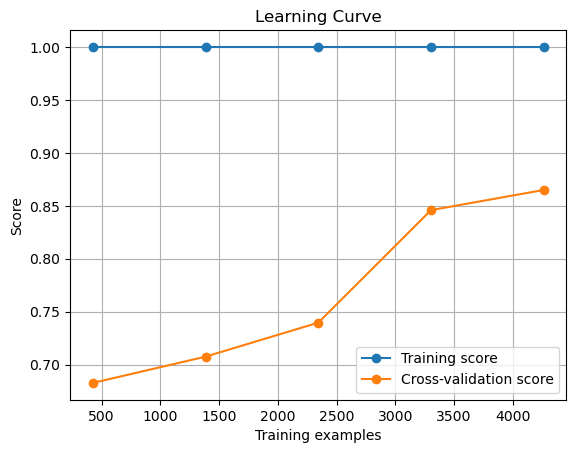

In [239]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(model, X, Y, cv=5, scoring='f1', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")

plt.legend(loc="best")
plt.show()


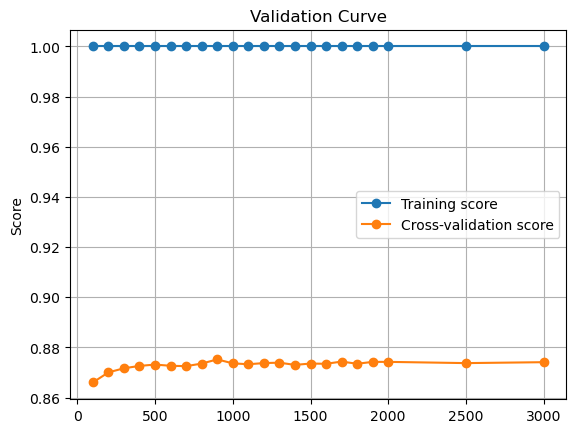

In [238]:
from sklearn.model_selection import validation_curve

param_range = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2500,3000] # 這裡是一個示例，你可以選擇不同的超參數值
# param_range = ['auto', 'sqrt', 'log2', None]
train_scores, test_scores = validation_curve(model, X, Y, param_name="n_estimators", param_range=param_range, cv=5, scoring='f1', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.title("Validation Curve")
plt.ylabel("Score")
plt.grid()

plt.plot(param_range, train_scores_mean, 'o-', label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', label="Cross-validation score")

plt.legend(loc="best")
plt.show()


## 儲存最終預測結果

In [23]:
predictions_df.to_csv('./predictions/70.csv', index=False)

<mark> 700(1)/566(0)<mark>